# **HW7 (10 Points): Required Submissions:**
1.  Submit  colab/jupyter notebooks.
2. Pdf version of the notebooks (HWs will not be graded if pdf version is not provided).
3. **The notebooks and pdf files should have the output.**
4. **Name files as follows : FirstName_file1_hw6, FirstName_file2_h6, FirstName_file3_h6, FirstName_file4_h6**

**Instructions**

- **You do not need to do EDA again. You can use the EDA from last HW. We are using the same datasets as in the last HW.**
- You might need to modify your pipeline as we we now using Tree based models that do not require lot of pre-processing.

# Question1 (10 Points) : Classification on the ‘credit-g’ dataset using SVM.

- **Use Halving GridsearchC OR HalvingRandomSerachCV OR Both for this problem**.
- **You are not allowed to use GridDSearchCV or RandomSearchCV for this HW**


Compare KNN/Logistic Regression/SVM.(previous HWs),  Basd on your anaysis which algorithm you will recommend.

# Download Data:
You can download the dataset using the commands below  and see it’s description at https://www.openml.org/d/31

### Attribute description from https://www.openml.org/d/31

1. Status of existing checking account, in Deutsche Mark.
2. Duration in months
3. Credit history (credits taken, paid back duly, delays, critical accounts)
4. Purpose of the credit (car, television,...)
5. Credit amount
6. Status of savings account/bonds, in Deutsche Mark.
7. Present employment, in number of years.
8. Installment rate in percentage of disposable income
9. Personal status (married, single,...) and sex
10. Other debtors / guarantors
11. Present residence since X years
12. Property (e.g. real estate)
13. Age in years
14. Other installment plans (banks, stores)
15. Housing (rent, own,...)
16. Number of existing credits at this bank
17. Job
18. Number of people being liable to provide maintenance for
19. Telephone (yes,no)
20. Foreign worker (yes,no)

In [1]:
if 'google.colab' in str(get_ipython()):
    print('Running on Colab')
else:
    print('Not Running on Colab')

Running on Colab


In [2]:
if 'google.colab' in str(get_ipython()):
  !pip install --upgrade feature_engine scikit-learn -q
  from google.colab import drive
  drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.9/328.9 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 20.8 MB/s eta 0:00:00
Mounted at /content/drive


In [3]:
!pip show scikit-learn

Name: scikit-learn
Version: 1.3.2
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: /usr/local/lib/python3.10/dist-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: bigframes, fastai, feature-engine, imbalanced-learn, librosa, mlxtend, qudida, sklearn-pandas, yellowbrick


In [4]:
!pip show feature_engine

Name: feature-engine
Version: 1.6.2
Summary: Feature engineering package with Scikit-learn's fit transform functionality
Home-page: http://github.com/feature-engine/feature_engine
Author: Soledad Galli
Author-email: solegalli@protonmail.com
License: BSD 3 clause
Location: /usr/local/lib/python3.10/dist-packages
Requires: numpy, pandas, scikit-learn, scipy, statsmodels
Required-by: 


In [5]:
"""Importing the required packages"""

# For DataFrames and manipulations
import pandas as pd
import numpy as np

# For data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
%matplotlib inline

# save and load models
import joblib

# Pathlib to navigate file system
from pathlib import Path
import sys

# For splitting the dataset
from sklearn.model_selection import train_test_split

# For categorical variables
from feature_engine.encoding import OneHotEncoder
from feature_engine.encoding import RareLabelEncoder
from feature_engine.encoding import DecisionTreeEncoder

# For scaling the data
from sklearn.preprocessing import StandardScaler

# creating pipelines
from sklearn.pipeline import Pipeline

# Hyper parameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import HalvingRandomSearchCV

# Using KNN classification for our data
from sklearn.neighbors import KNeighborsClassifier

# draws a confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

# We will use this to download the Dataset
from sklearn.datasets import fetch_openml

# feature engine log transformation
from feature_engine.transformation import LogTransformer

# feature engine wrapper
from feature_engine.wrappers import SklearnTransformerWrapper

from sklearn.ensemble import RandomForestClassifier

import warnings

# Disable all warnings
warnings.filterwarnings("ignore")

from scipy.stats import uniform, truncnorm, randint, loguniform

In [6]:
base_folder = Path('/content/drive/MyDrive/BUAN6341/HW7/')

In [7]:
data_folder = base_folder/'datasets'
save_model_folder = base_folder/'models/ml_fall_2022'
custom_function_folder = base_folder/'custom-functions'
save_model_folder.mkdir(exist_ok=True, parents=True)

In [8]:
%load_ext autoreload
%autoreload 2

In [9]:
sys.path.append(str(custom_function_folder))

In [10]:
sys.path

['/content',
 '/env/python',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.10/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/drive/MyDrive/BUAN6341/HW7/custom-functions']

In [11]:
from  plot_learning_curve import plot_learning_curve

In [12]:
from eda_plots import diagnostic_plots, plot_target_by_category

In [13]:
# Load data from  https://www.openml.org/d/31
X, y = fetch_openml("credit-g", version=1, as_frame=True, return_X_y=True)

In [14]:
X.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
0,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,4.0,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes
1,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,2.0,real estate,22.0,none,own,1.0,skilled,1.0,none,yes
2,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,3.0,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes
3,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,male single,guarantor,4.0,life insurance,45.0,none,for free,1.0,skilled,2.0,none,yes
4,<0,24.0,delayed previously,new car,4870.0,<100,1<=X<4,3.0,male single,none,4.0,no known property,53.0,none,for free,2.0,skilled,2.0,none,yes


In [15]:
y.head()

0    good
1     bad
2    good
3    good
4     bad
Name: class, dtype: category
Categories (2, object): ['bad', 'good']

In [16]:
# check the top 5 rows
X.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
0,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,4.0,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes
1,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,2.0,real estate,22.0,none,own,1.0,skilled,1.0,none,yes
2,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,3.0,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes
3,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,male single,guarantor,4.0,life insurance,45.0,none,for free,1.0,skilled,2.0,none,yes
4,<0,24.0,delayed previously,new car,4870.0,<100,1<=X<4,3.0,male single,none,4.0,no known property,53.0,none,for free,2.0,skilled,2.0,none,yes


In [17]:
# Let's check the columns of the data
X.columns

Index(['checking_status', 'duration', 'credit_history', 'purpose',
       'credit_amount', 'savings_status', 'employment',
       'installment_commitment', 'personal_status', 'other_parties',
       'residence_since', 'property_magnitude', 'age', 'other_payment_plans',
       'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone',
       'foreign_worker'],
      dtype='object')

In [18]:
# check the data type for the columns
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   checking_status         1000 non-null   category
 1   duration                1000 non-null   float64 
 2   credit_history          1000 non-null   category
 3   purpose                 1000 non-null   category
 4   credit_amount           1000 non-null   float64 
 5   savings_status          1000 non-null   category
 6   employment              1000 non-null   category
 7   installment_commitment  1000 non-null   float64 
 8   personal_status         1000 non-null   category
 9   other_parties           1000 non-null   category
 10  residence_since         1000 non-null   float64 
 11  property_magnitude      1000 non-null   category
 12  age                     1000 non-null   float64 
 13  other_payment_plans     1000 non-null   category
 14  housing                 1

In [19]:
# Identify Columns that Contain a Single value
# we will use nunique() function to get number of unique values for each column
# We can delete the columns which have single values
X.nunique()

checking_status             4
duration                   33
credit_history              5
purpose                    10
credit_amount             921
savings_status              5
employment                  5
installment_commitment      4
personal_status             4
other_parties               3
residence_since             4
property_magnitude          4
age                        53
other_payment_plans         3
housing                     3
existing_credits            4
job                         4
num_dependents              2
own_telephone               2
foreign_worker              2
dtype: int64

In [20]:
# We will use describe function and then take the transpose for better visualization
X.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,1000.0,20.903,12.058814,4.0,12.0,18.0,24.00,72.0
credit_amount,1000.0,3271.258,2822.736876,250.0,1365.5,2319.5,3972.25,18424.0
installment_commitment,1000.0,2.973,1.118715,1.0,2.0,3.0,4.00,4.0
residence_since,1000.0,2.845,1.103718,1.0,2.0,3.0,4.00,4.0
age,1000.0,35.546,11.375469,19.0,27.0,33.0,42.00,75.0
existing_credits,1000.0,1.407,0.577654,1.0,1.0,1.0,2.00,4.0
num_dependents,1000.0,1.155,0.362086,1.0,1.0,1.0,1.00,2.0


In [21]:
# To check the duplicates of the data
dups = X.duplicated()
# report if there are any duplicates
print(dups.any())

False


In [22]:
# check missing values in data
X.isna()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
996,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
997,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
998,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [23]:
X.isna().mean()*100

checking_status           0.0
duration                  0.0
credit_history            0.0
purpose                   0.0
credit_amount             0.0
savings_status            0.0
employment                0.0
installment_commitment    0.0
personal_status           0.0
other_parties             0.0
residence_since           0.0
property_magnitude        0.0
age                       0.0
other_payment_plans       0.0
housing                   0.0
existing_credits          0.0
job                       0.0
num_dependents            0.0
own_telephone             0.0
foreign_worker            0.0
dtype: float64

In [24]:
# Create a list of categorical variables
# Since the dtype of categorical variable is Object we can compare the values with 'O'
categorical = [var for var in X.columns if X[var].dtype.name == 'category']

# Create a list of discrete variables
# we do not want to consider Exited as this is target variable
discrete = [
    var for var in X.columns if X[var].dtype.name != 'category'
    and len(X[var].unique()) < 20
]

# Create a list of continuous Variables
continuous = [
    var for var in X.columns if X[var].dtype.name != 'category'
    if var not in discrete
]

In [25]:
categorical

['checking_status',
 'credit_history',
 'purpose',
 'savings_status',
 'employment',
 'personal_status',
 'other_parties',
 'property_magnitude',
 'other_payment_plans',
 'housing',
 'job',
 'own_telephone',
 'foreign_worker']

In [26]:
discrete

['installment_commitment',
 'residence_since',
 'existing_credits',
 'num_dependents']

In [27]:
# Check number of unique values for discrete variables
total_unique_values= X[discrete].nunique()
for key, value in total_unique_values.items():
    if value > 0:
        print(key,":",value)

installment_commitment : 4
residence_since : 4
existing_credits : 4
num_dependents : 2


In [28]:
for var in discrete:
    print(var, X[var].unique(), '\n')

installment_commitment [4. 2. 3. 1.] 

residence_since [4. 2. 3. 1.] 

existing_credits [2. 1. 3. 4.] 

num_dependents [1. 2.] 



In [29]:
# Check number of unique values for continuous variables
total_unique_values= X[continuous].nunique()
for key,value in total_unique_values.items():
    if value >0:
        print(key,":",value)

duration : 33
credit_amount : 921
age : 53


In [30]:
for var in continuous:
    print(var, X[var].unique()[0:20], '\n')

duration [ 6. 48. 12. 42. 24. 36. 30. 15.  9. 10.  7. 60. 18. 45. 11. 27.  8. 54.
 20. 14.] 

credit_amount [ 1169.  5951.  2096.  7882.  4870.  9055.  2835.  6948.  3059.  5234.
  1295.  4308.  1567.  1199.  1403.  1282.  2424.  8072. 12579.  3430.] 

age [67. 22. 49. 45. 53. 35. 61. 28. 25. 24. 60. 32. 44. 31. 48. 26. 36. 39.
 42. 34.] 



In [31]:
total_unique_values= X[categorical].nunique()
for key,value in total_unique_values.items():
    if value >0:
        print(key,":",value)

checking_status : 4
credit_history : 5
purpose : 10
savings_status : 5
employment : 5
personal_status : 4
other_parties : 3
property_magnitude : 4
other_payment_plans : 3
housing : 3
job : 4
own_telephone : 2
foreign_worker : 2


In [32]:
for var in categorical:
    print(var, X[var].unique(), '\n')

checking_status ['<0', '0<=X<200', 'no checking', '>=200']
Categories (4, object): ['0<=X<200', '<0', '>=200', 'no checking'] 

credit_history ['critical/other existing credit', 'existing paid', 'delayed previously', 'no credits/all paid', 'all paid']
Categories (5, object): ['all paid', 'critical/other existing credit', 'delayed previously',
                         'existing paid', 'no credits/all paid'] 

purpose ['radio/tv', 'education', 'furniture/equipment', 'new car', 'used car', 'business', 'domestic appliance', 'repairs', 'other', 'retraining']
Categories (10, object): ['business', 'domestic appliance', 'education', 'furniture/equipment',
                          ..., 'radio/tv', 'repairs', 'retraining', 'used car'] 

savings_status ['no known savings', '<100', '500<=X<1000', '>=1000', '100<=X<500']
Categories (5, object): ['100<=X<500', '500<=X<1000', '<100', '>=1000', 'no known savings'] 

employment ['>=7', '1<=X<4', '4<=X<7', 'unemployed', '<1']
Categories (5, object): ['

In [33]:
def check_rare(var):
  cat_freq = 100 * X[var].value_counts(normalize=True)
  fig = cat_freq.sort_values(ascending=False).plot.bar()
  fig.axhline(y=5, color='red')
  fig.set_ylabel('category percentage frequency')
  fig.set_xlabel(var)
  fig.set_title('Identifying Rare Categories')
  plt.show()

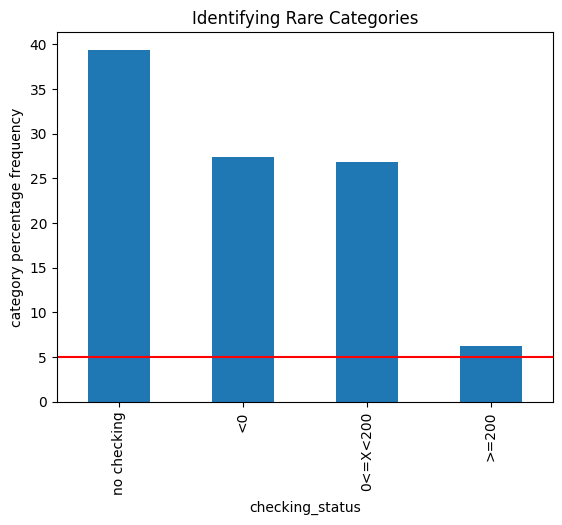

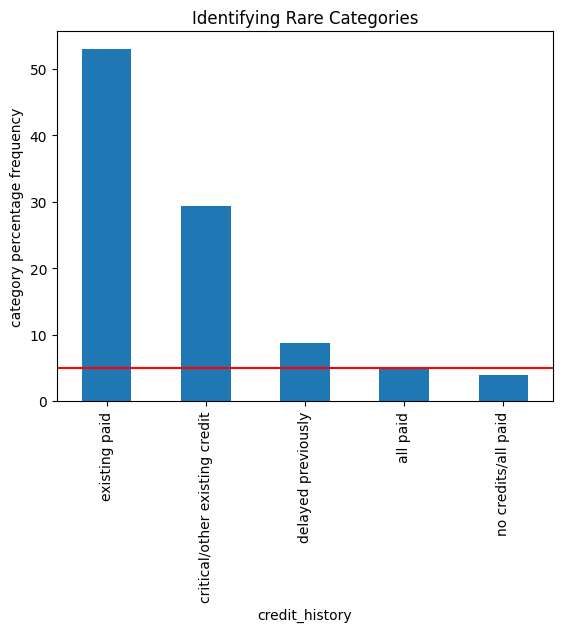

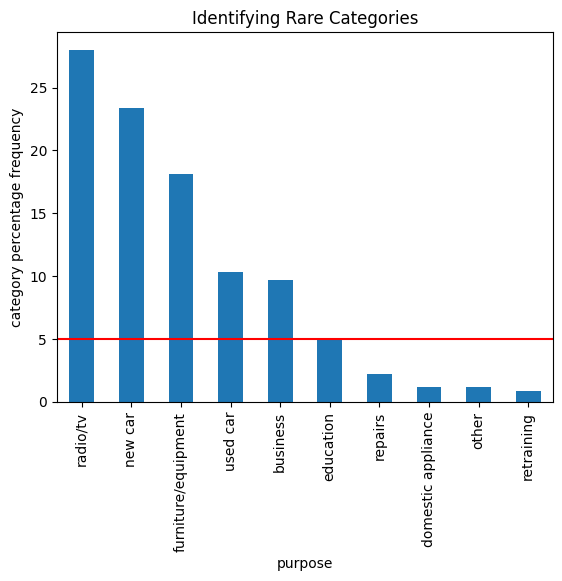

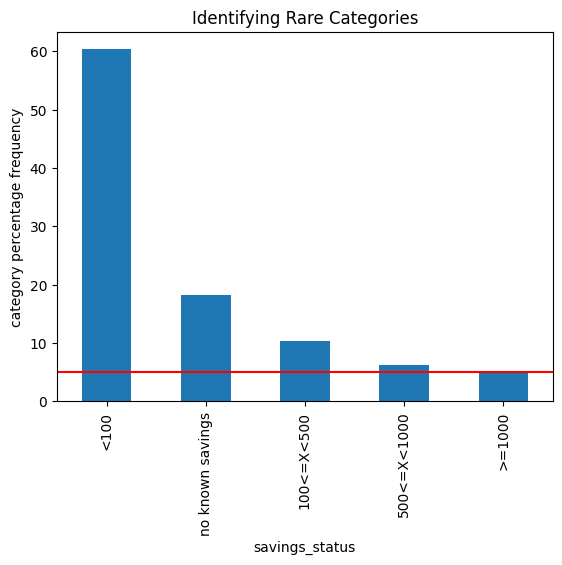

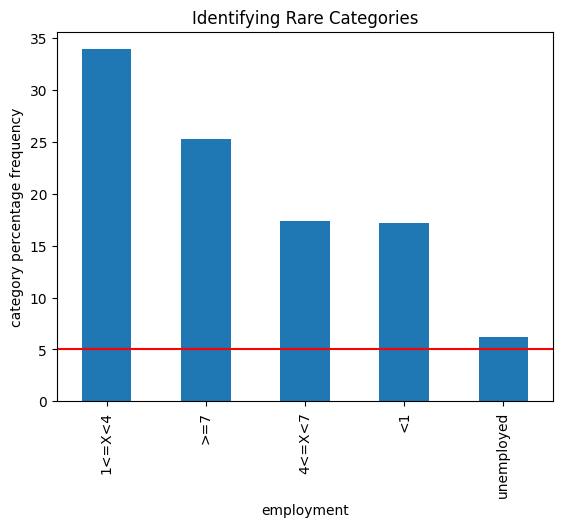

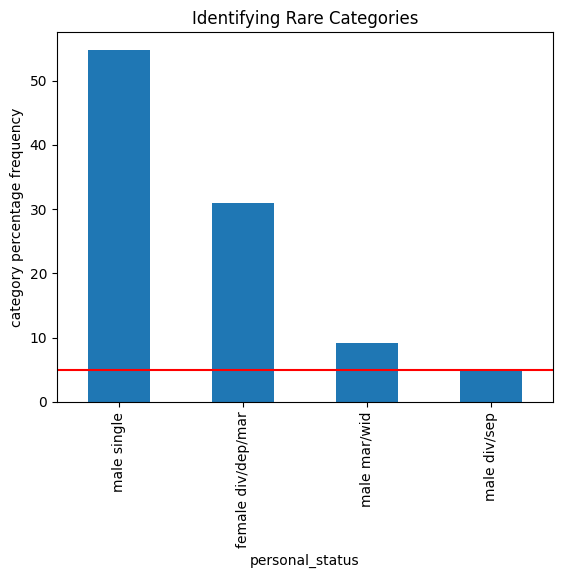

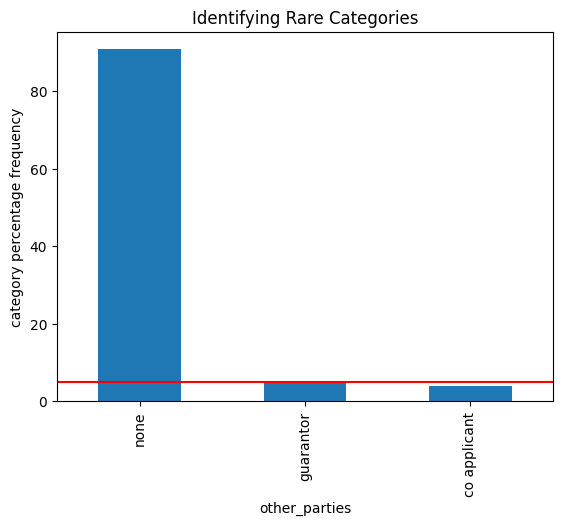

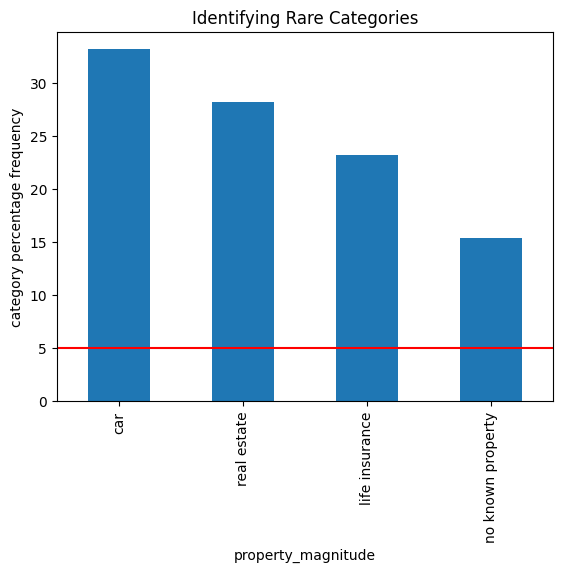

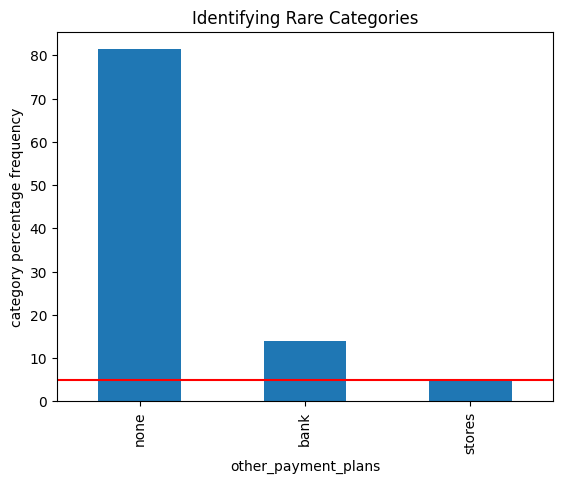

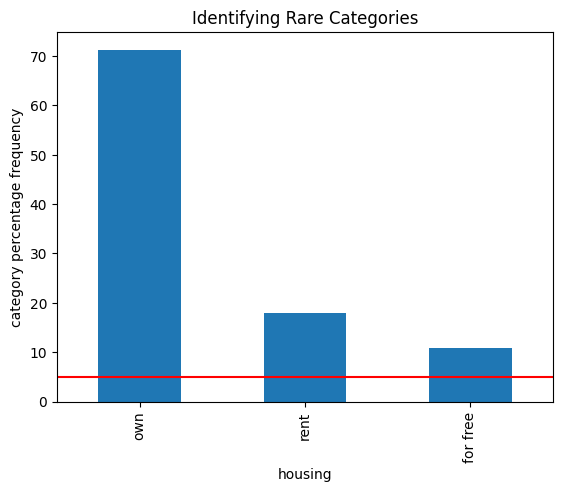

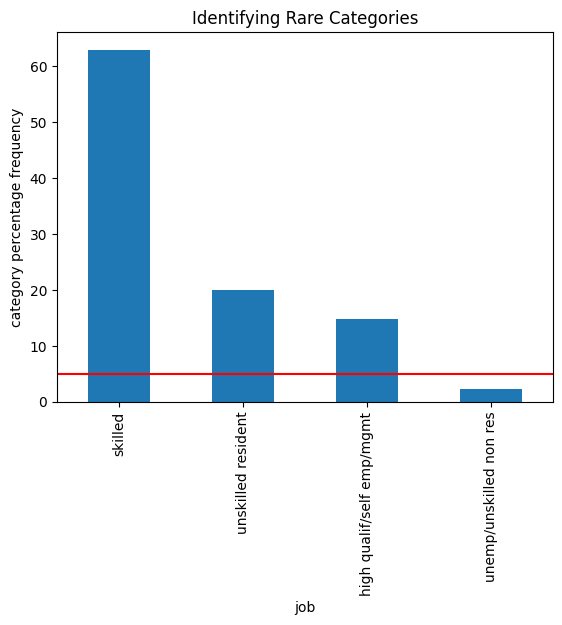

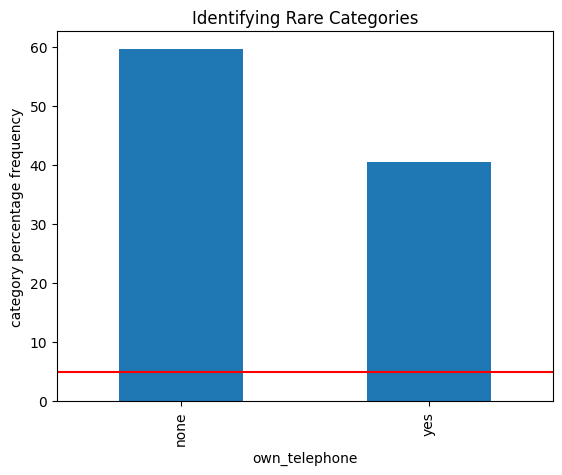

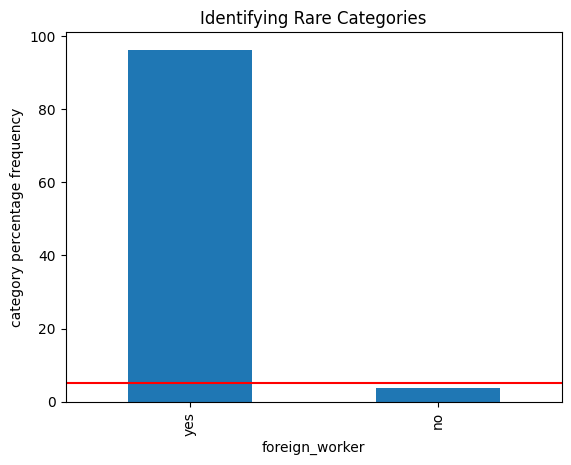

In [34]:
for var in categorical:
  check_rare(var)

In [35]:
print(f"{100 * y.value_counts(normalize=True)} ")

good    70.0
bad     30.0
Name: class, dtype: float64 


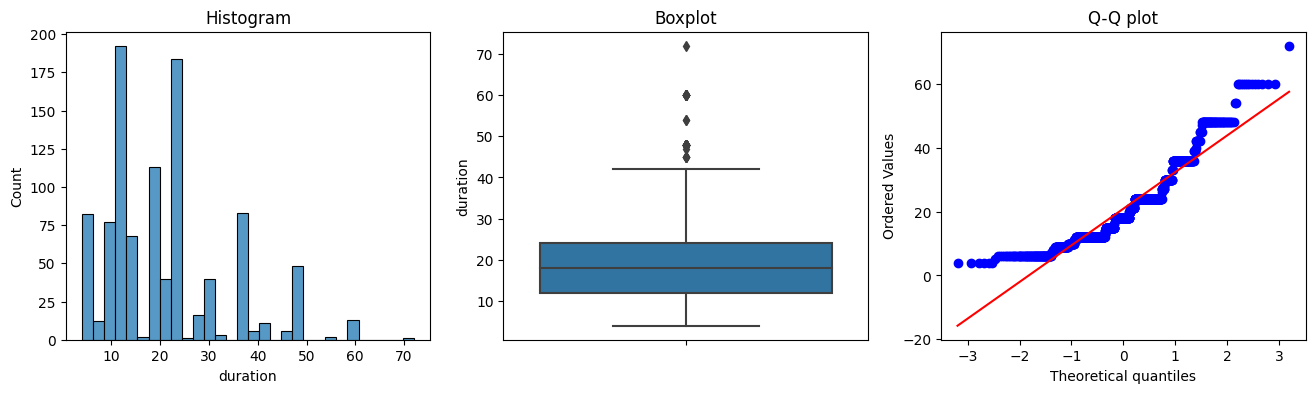

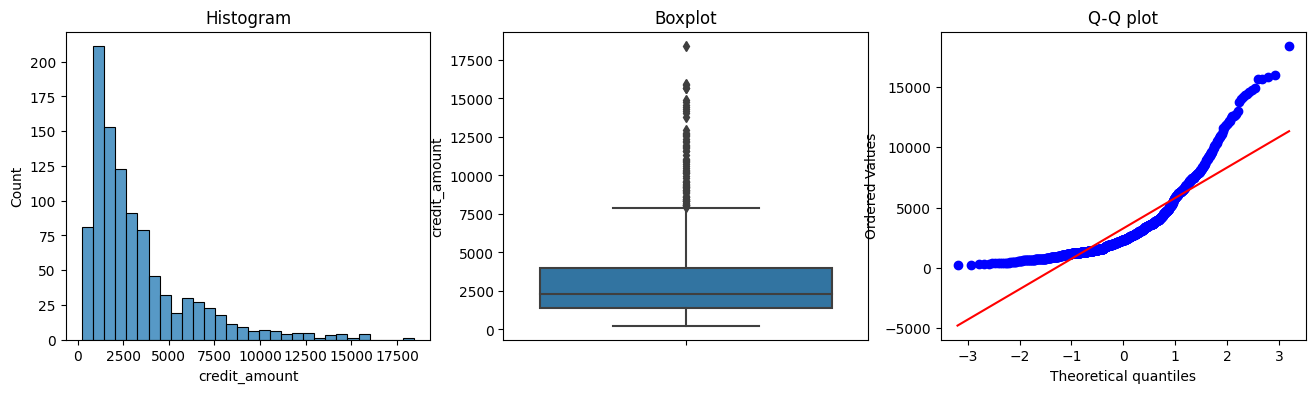

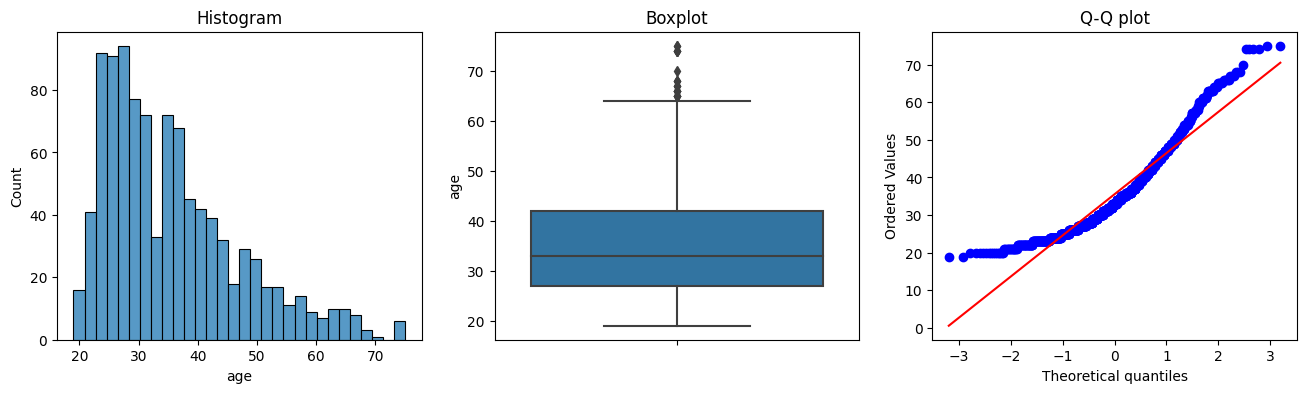

In [36]:
for var in continuous:
    diagnostic_plots(X, var)

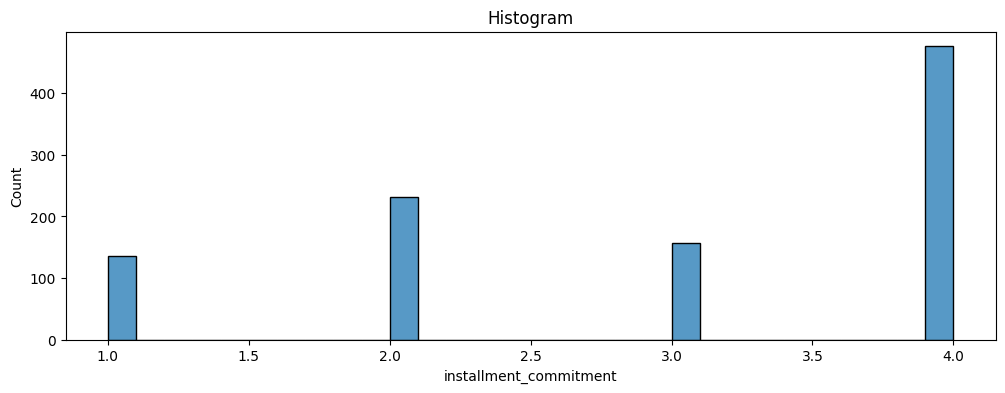

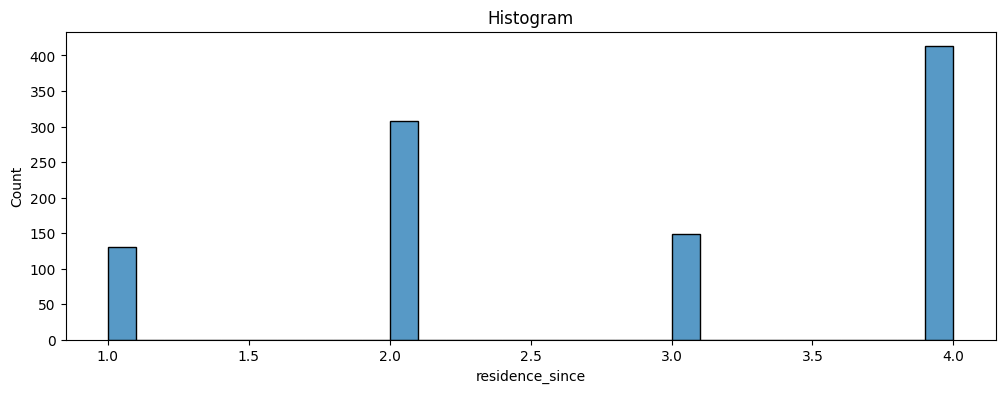

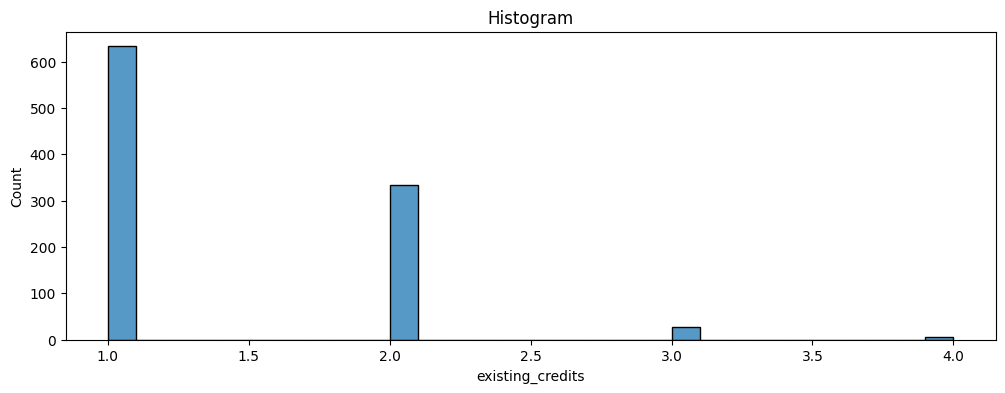

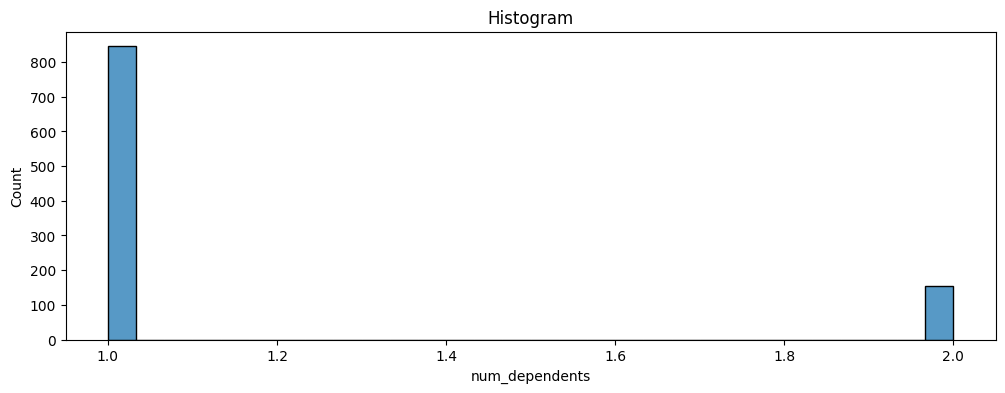

In [37]:
# histograms for discrete variables
for var in discrete:
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 1, 1)
    sns.histplot(X[var], bins=30)
    plt.title('Histogram')

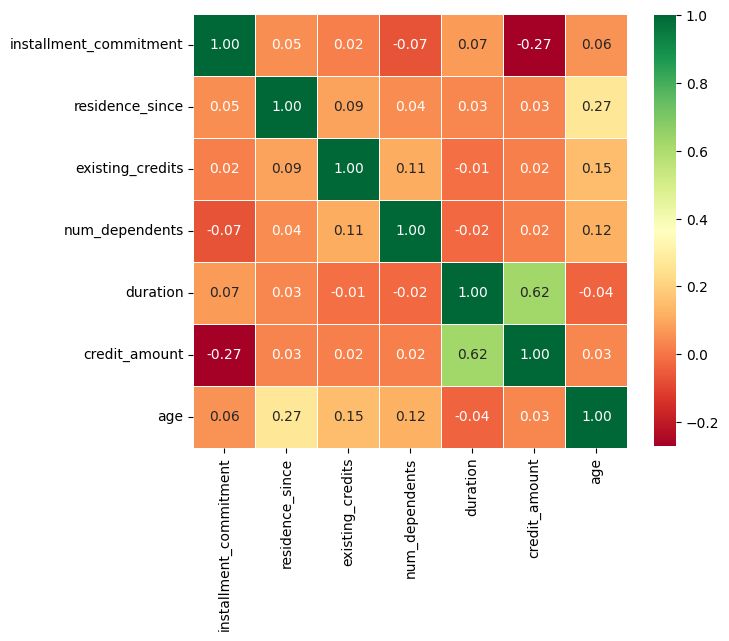

In [38]:
# We can check the correlation between every pair of attributes
# The correlation will be generated for the numerical data only
# we will use df.corr() to get correlatons and then use sns.heatmap to print the correlation matrix
corrmat = X[discrete + continuous].corr().round(2)
top_corr_features = corrmat.index
plt.figure(figsize=(7, 7))
sns.heatmap(X[top_corr_features].corr(),annot=True, square=True, fmt='.2f',
            cbar_kws={"shrink": .80}, linewidths=.5, cmap='RdYlGn');

In [39]:
df = pd.concat([X, y], axis = 1)

In [40]:
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,...,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes,good
1,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,...,real estate,22.0,none,own,1.0,skilled,1.0,none,yes,bad
2,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,...,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes,good
3,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,male single,guarantor,...,life insurance,45.0,none,for free,1.0,skilled,2.0,none,yes,good
4,<0,24.0,delayed previously,new car,4870.0,<100,1<=X<4,3.0,male single,none,...,no known property,53.0,none,for free,2.0,skilled,2.0,none,yes,bad


In [41]:
df.rename({'class': 'target'}, axis = 1, inplace=True)

In [42]:
df['target'] = df['target'].map({'good':0, 'bad':1})

In [43]:
df = df.astype({'target': 'int32'})

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   checking_status         1000 non-null   category
 1   duration                1000 non-null   float64 
 2   credit_history          1000 non-null   category
 3   purpose                 1000 non-null   category
 4   credit_amount           1000 non-null   float64 
 5   savings_status          1000 non-null   category
 6   employment              1000 non-null   category
 7   installment_commitment  1000 non-null   float64 
 8   personal_status         1000 non-null   category
 9   other_parties           1000 non-null   category
 10  residence_since         1000 non-null   float64 
 11  property_magnitude      1000 non-null   category
 12  age                     1000 non-null   float64 
 13  other_payment_plans     1000 non-null   category
 14  housing                 1

In [45]:
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,target
0,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,...,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes,0
1,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,...,real estate,22.0,none,own,1.0,skilled,1.0,none,yes,1
2,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,...,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes,0
3,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,male single,guarantor,...,life insurance,45.0,none,for free,1.0,skilled,2.0,none,yes,0
4,<0,24.0,delayed previously,new car,4870.0,<100,1<=X<4,3.0,male single,none,...,no known property,53.0,none,for free,2.0,skilled,2.0,none,yes,1


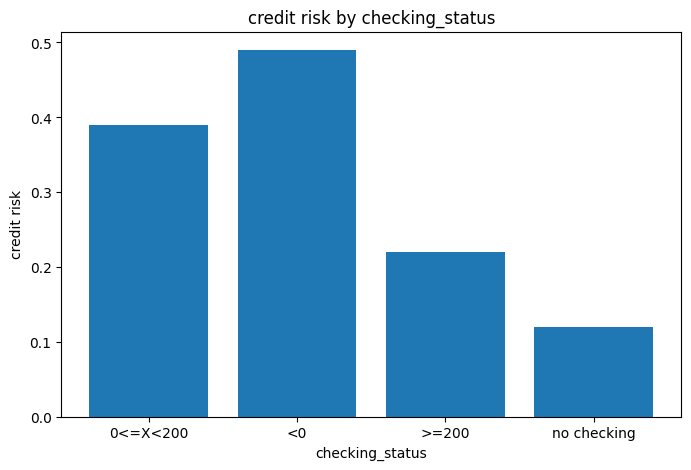

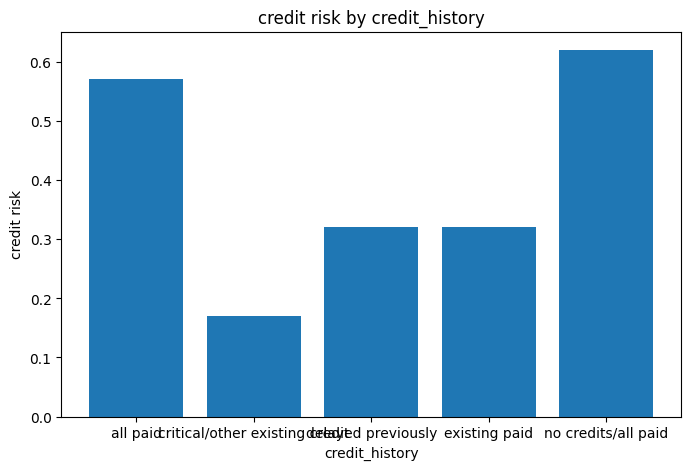

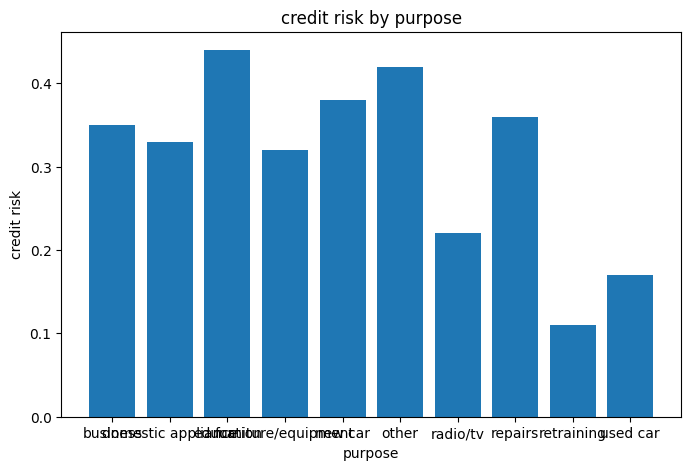

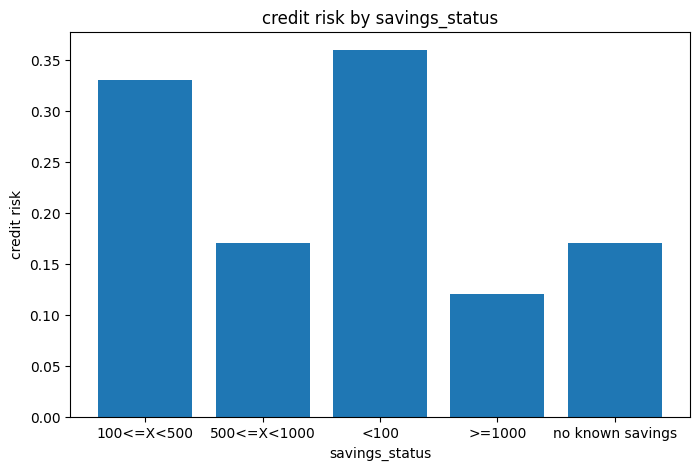

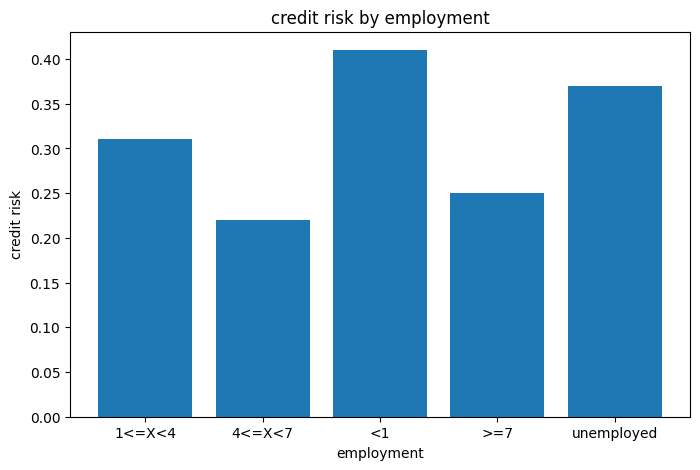

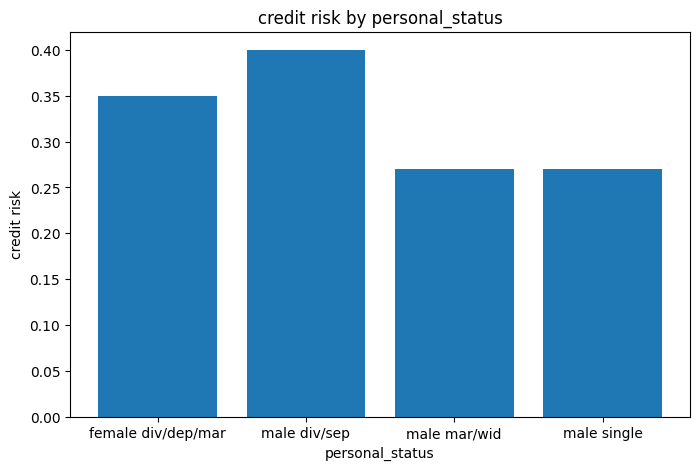

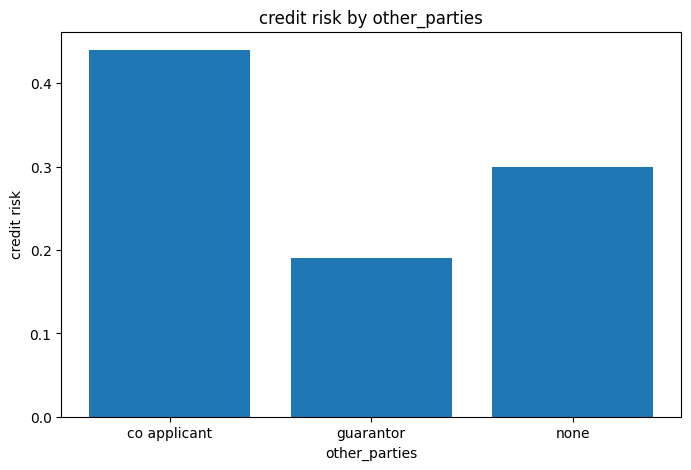

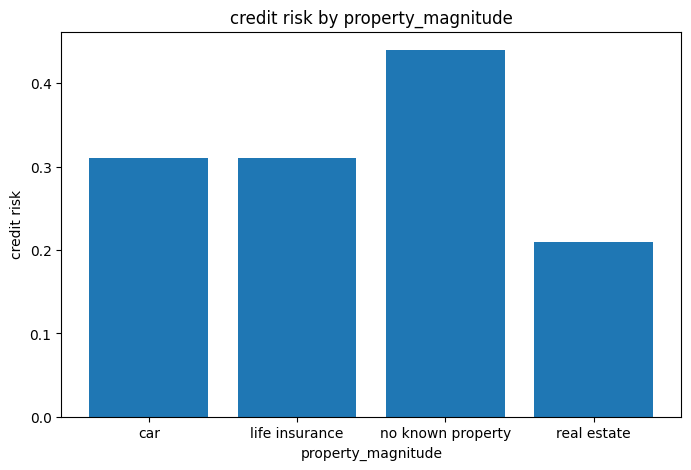

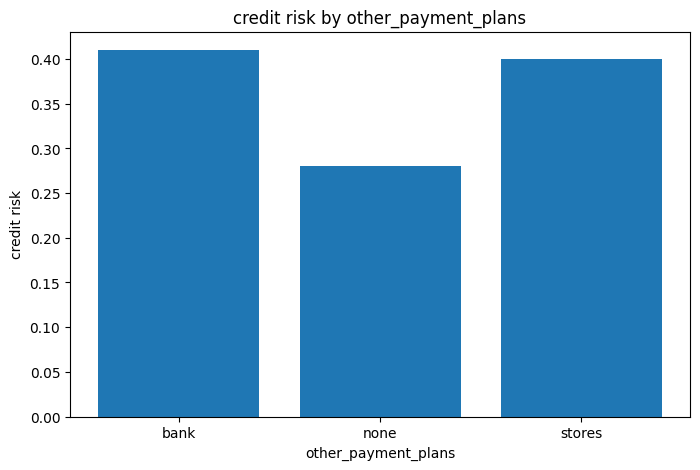

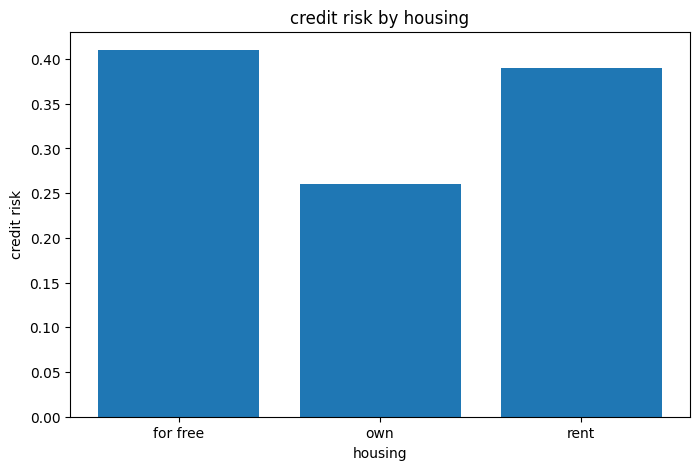

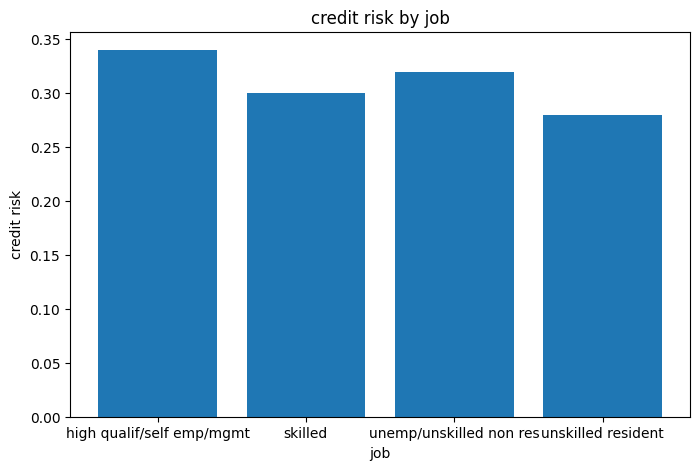

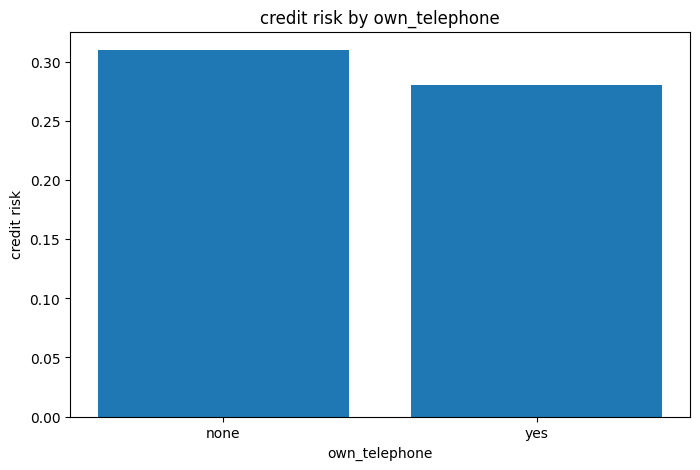

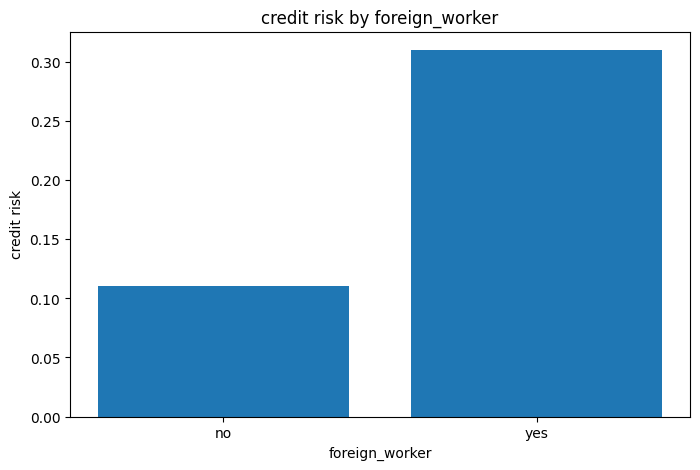

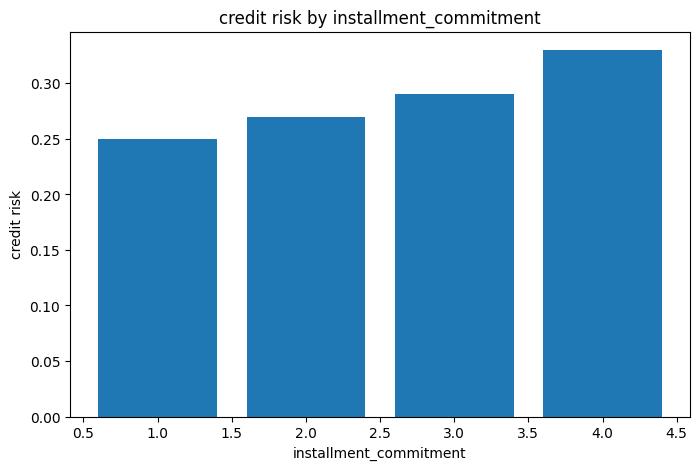

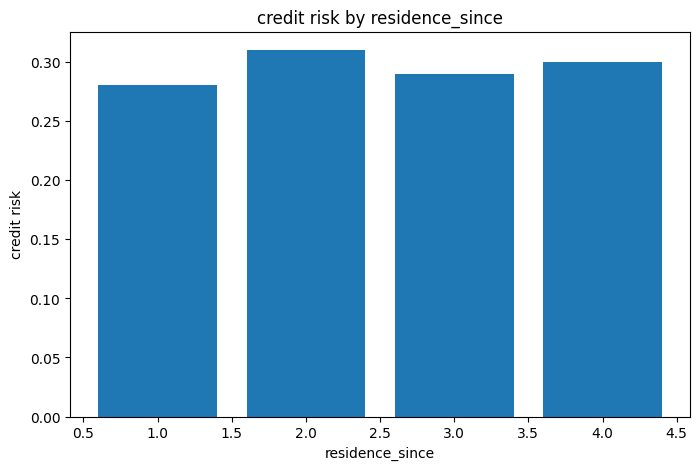

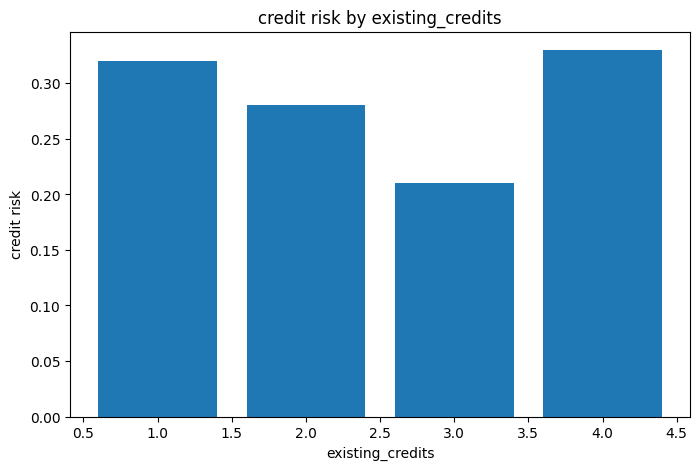

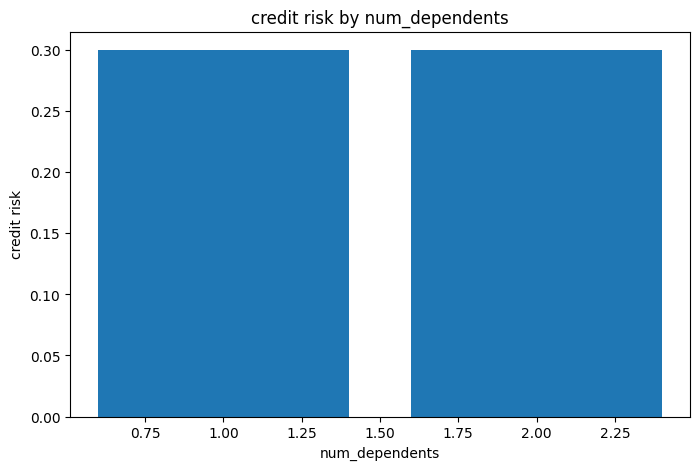

In [46]:
# Plotting all categorical and discrete features using above function.
for category in categorical + discrete:
  plot_target_by_category(df, 'target',category,'credit risk')

In [47]:
# before doing any data cleaning step we need to first split the data into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=123, stratify =y)

In [48]:
X_train.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
356,no checking,12.0,critical/other existing credit,radio/tv,2331.0,no known savings,>=7,1.0,male single,co applicant,4.0,real estate,49.0,none,own,1.0,skilled,1.0,yes,yes
344,>=200,10.0,existing paid,new car,3949.0,<100,<1,1.0,male single,guarantor,1.0,life insurance,37.0,none,own,1.0,unskilled resident,2.0,none,yes
236,0<=X<200,6.0,existing paid,new car,14555.0,no known savings,unemployed,1.0,male single,none,2.0,life insurance,23.0,none,own,1.0,unemp/unskilled non res,1.0,yes,yes
699,>=200,15.0,existing paid,education,1905.0,<100,>=7,4.0,male single,none,4.0,car,40.0,none,rent,1.0,high qualif/self emp/mgmt,1.0,yes,yes
424,0<=X<200,12.0,existing paid,furniture/equipment,2762.0,no known savings,>=7,1.0,female div/dep/mar,none,2.0,life insurance,25.0,bank,own,1.0,skilled,1.0,yes,yes


In [49]:
y_train

356    good
344    good
236     bad
699    good
424     bad
       ... 
124     bad
923    good
362    good
217    good
200    good
Name: class, Length: 670, dtype: category
Categories (2, object): ['bad', 'good']

In [50]:
print(f'Length of X_train: {len(X_train)}')
print(f'Length of X_test: {len(X_test)}')

Length of X_train: 670
Length of X_test: 330


In [51]:
print(f'Length of y_train: {len(y_train)}')
print(f'Length of y_test: {len(y_test)}')

Length of y_train: 670
Length of y_test: 330


##  Pipeline 1

In [52]:
var_rare_labels= [
 'credit_history',
 'purpose',
 'savings_status',
 'personal_status',
 'other_parties',
 'other_payment_plans',
 'job']

In [53]:
continuous

['duration', 'credit_amount', 'age']

In [54]:
discrete

['installment_commitment',
 'residence_since',
 'existing_credits',
 'num_dependents']

In [55]:
categorical

['checking_status',
 'credit_history',
 'purpose',
 'savings_status',
 'employment',
 'personal_status',
 'other_parties',
 'property_magnitude',
 'other_payment_plans',
 'housing',
 'job',
 'own_telephone',
 'foreign_worker']

In [56]:
from sklearn.base import BaseEstimator, TransformerMixin
class ConvertToNumpyArray(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array(X)

In [57]:
credit_risk_pipeline_1 = Pipeline([

    ('rare_label_encoder',
      RareLabelEncoder(tol=0.05, variables=var_rare_labels)),

    ('one_hot_encoder',
     OneHotEncoder(variables=categorical + discrete, drop_last=True, ignore_format=True)),

    ('convert_to_numpy', ConvertToNumpyArray()),

    ('rfc',
     RandomForestClassifier(oob_score=True,random_state=42))
])

In [58]:
param_grid_1 = {
    'rfc__n_estimators': [200, 300, 400],
    'rfc__max_features': ['auto', 'sqrt', 'log2'],
    'rfc__max_depth': [2, 4, 5, 6, 7, 8],
    'rfc__criterion': ['gini', 'entropy']
}

grid_rfc_1 = HalvingGridSearchCV(credit_risk_pipeline_1, param_grid=param_grid_1, cv=5, return_train_score=True)

In [59]:
grid_rfc_1.fit(X_train, y_train)

HalvingGridSearchCV(estimator=Pipeline(steps=[('rare_label_encoder',
                                               RareLabelEncoder(variables=['credit_history',
                                                                           'purpose',
                                                                           'savings_status',
                                                                           'personal_status',
                                                                           'other_parties',
                                                                           'other_payment_plans',
                                                                           'job'])),
                                              ('one_hot_encoder',
                                               OneHotEncoder(drop_last=True,
                                                             ignore_format=True,
                                                             variables=['checking_status',
                                                                        'credit_history',
                                                                        'purpose',
                                                                        'savings_status',
                                                                        'empl...
                                                                        'foreign_worker',
                                                                        'installment_commitment',
                                                                        'residence_since',
                                                                        'existing_credits',
                                                                        'num_dependents'])),
                                              ('convert_to_numpy',
                                               ConvertToNumpyArray()),
                                              ('rfc',
                                               RandomForestClassifier(oob_score=True,
                                                                      random_state=42))]),
                    param_grid={'rfc__criterion': ['gini', 'entropy'],
                                'rfc__max_depth': [2, 4, 5, 6, 7, 8],
                                'rfc__max_features': ['auto', 'sqrt', 'log2'],
                                'rfc__n_estimators': [200, 300, 400]})

In [60]:
print(grid_rfc_1.best_params_)

{'rfc__criterion': 'gini', 'rfc__max_depth': 7, 'rfc__max_features': 'sqrt', 'rfc__n_estimators': 400}


In [61]:
# Here  save_model_folder is folder where I have saved models. Change that to appropriate location.
# This variable is defined in section Mount Google Drive, Import Data

# specify the file to save the best estimator
file_best_estimator_round1 = save_model_folder / 'rfc_round1_best_estimator.pkl'

# specify the file to save complete grid results
file_complete_grid_round1 = save_model_folder / 'rfc_round1_complete_grid.pkl'

In [62]:
# save the best estimator
joblib.dump(grid_rfc_1.best_estimator_, file_best_estimator_round1)

# save complete grid results
joblib.dump(grid_rfc_1, file_complete_grid_round1)

['/content/drive/MyDrive/BUAN6341/HW7/models/ml_fall_2022/rfc_round1_complete_grid.pkl']

In [63]:
# load  the best estimator
loaded_best_estimator_round1 = joblib.load(file_best_estimator_round1)

# load complete grid results
loaded_complete_grid_round1 = joblib.load(file_complete_grid_round1)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

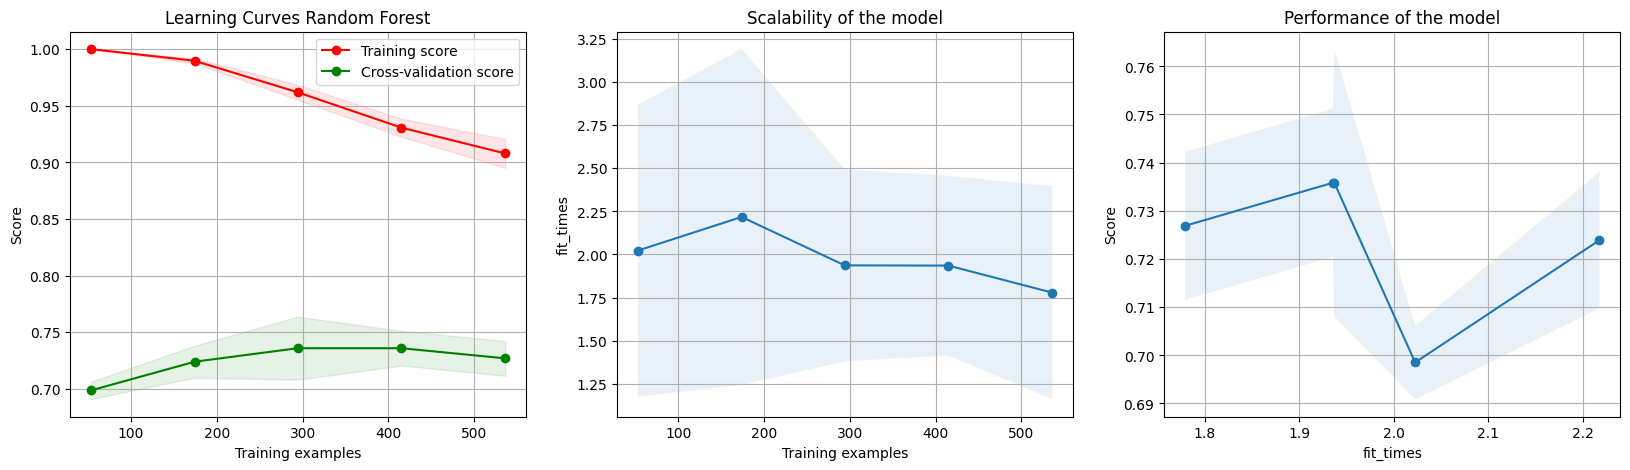

In [64]:
# plot learning curves

plot_learning_curve(loaded_best_estimator_round1, 'Learning Curves Random Forest', X_train, y_train, n_jobs=-1)

In [65]:
# Check the train scores
# to check the train scores we will use loaded best estinator

print(loaded_best_estimator_round1.score(X_train, y_train))

# check the cross validation score
# To check the cross validation score we need to use the loaded complete grid results

print(loaded_complete_grid_round1.best_score_)

0.8880597014925373
0.7499999999999999


## Pipeline 2

In [66]:
credit_risk_preprocessing = Pipeline([

    ('rare_label_encoder',
      RareLabelEncoder(tol=0.05, variables=var_rare_labels)),

    ('one_hot_encoder',
     OneHotEncoder(variables=categorical + discrete, drop_last=True, ignore_format=True)),

    ('convert_to_numpy', ConvertToNumpyArray())
])

In [67]:
credit_risk_pipeline_2 = Pipeline([

    ('rare_label_encoder',
      RareLabelEncoder(tol=0.05, variables=var_rare_labels)),

    ('one_hot_encoder',
     OneHotEncoder(variables=categorical + discrete, drop_last=True, ignore_format=True)),

    ('convert_to_numpy', ConvertToNumpyArray()),

    ('rfc', RandomForestClassifier(oob_score=True, random_state=42))
])

In [68]:
# Preprocessing - Train data
X_train_processed = credit_risk_preprocessing.fit_transform(X_train)

In [69]:
train_scores = []
oob_scores = []
best_oob_score = 0
best_n_estimators = 50

rfc = RandomForestClassifier(warm_start=True, random_state=42, oob_score=True)
estimator_range = range(50, 500, 10)
for n_estimators in estimator_range:
    rfc.n_estimators = n_estimators
    rfc.fit(X_train_processed, y_train)
    train_scores.append(rfc.score(X_train_processed, y_train))
    oob_scores.append(rfc.oob_score_)
    if rfc.oob_score_ > best_oob_score:
        best_n_estimators = n_estimators
        best_oob_score = rfc.oob_score_


In [70]:
print(best_n_estimators)

380


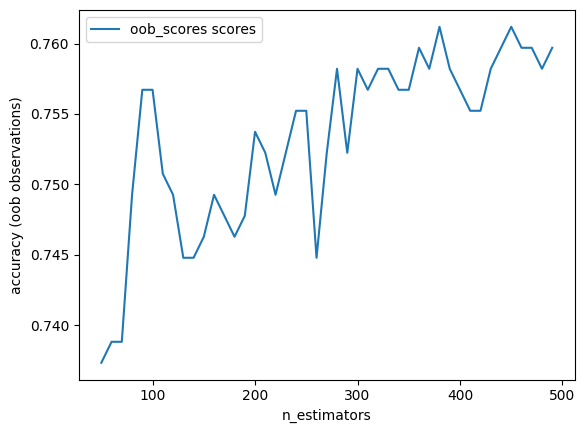

In [71]:
plt.plot(estimator_range, oob_scores, label="oob_scores scores")
plt.ylabel("accuracy (oob observations)")
plt.xlabel("n_estimators")
plt.legend()
plt.show()

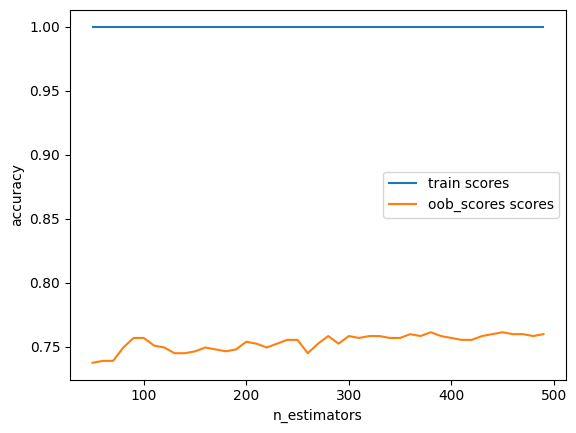

In [72]:
plt.plot(estimator_range, train_scores, label="train scores")
plt.plot(estimator_range, oob_scores, label="oob_scores scores")
plt.ylabel("accuracy")
plt.xlabel("n_estimators")
plt.legend()
plt.show()

In [74]:
param_grid_2= {
    'rfc__n_estimators': [380],
    'rfc__max_features': ["sqrt", "log2", None],
    'rfc__max_depth': np.arange(2,10)
    }


# now we set up the halving grid search with cross-validation
grid_rf_2 = HalvingGridSearchCV(credit_risk_pipeline_2, param_grid=param_grid_2, cv=5, return_train_score= True, n_jobs=-1)

In [76]:
grid_rf_2.fit(X_train, y_train)

HalvingGridSearchCV(estimator=Pipeline(steps=[('rare_label_encoder',
                                               RareLabelEncoder(variables=['credit_history',
                                                                           'purpose',
                                                                           'savings_status',
                                                                           'personal_status',
                                                                           'other_parties',
                                                                           'other_payment_plans',
                                                                           'job'])),
                                              ('one_hot_encoder',
                                               OneHotEncoder(drop_last=True,
                                                             ignore_format=True,
                                                             variables=['checking_status',
                                                                        'credit_history',
                                                                        'purpose',
                                                                        'savings_status',
                                                                        'empl...
                                                                        'own_telephone',
                                                                        'foreign_worker',
                                                                        'installment_commitment',
                                                                        'residence_since',
                                                                        'existing_credits',
                                                                        'num_dependents'])),
                                              ('convert_to_numpy',
                                               ConvertToNumpyArray()),
                                              ('rfc',
                                               RandomForestClassifier(oob_score=True,
                                                                      random_state=42))]),
                    n_jobs=-1,
                    param_grid={'rfc__max_depth': array([2, 3, 4, 5, 6, 7, 8, 9]),
                                'rfc__max_features': ['sqrt', 'log2', None],
                                'rfc__n_estimators': [380]})

In [77]:
grid_rf_2.best_params_

{'rfc__max_depth': 8, 'rfc__max_features': None, 'rfc__n_estimators': 380}

In [78]:
file_best_estimator_round2 = save_model_folder / 'rfc_round2_best_estimator.pk'
file_complete_grid_round2 = save_model_folder / 'rfc_round2_complete_grid.pkl'

In [79]:
joblib.dump(grid_rf_2.best_estimator_, file_best_estimator_round2)
joblib.dump(grid_rf_2, file_complete_grid_round2)

['/content/drive/MyDrive/BUAN6341/HW7/models/ml_fall_2022/rfc_round2_complete_grid.pkl']

In [80]:
loaded_best_estimator_round2 = joblib.load(file_best_estimator_round2)
loaded_complete_grid_round2 = joblib.load(file_complete_grid_round2)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

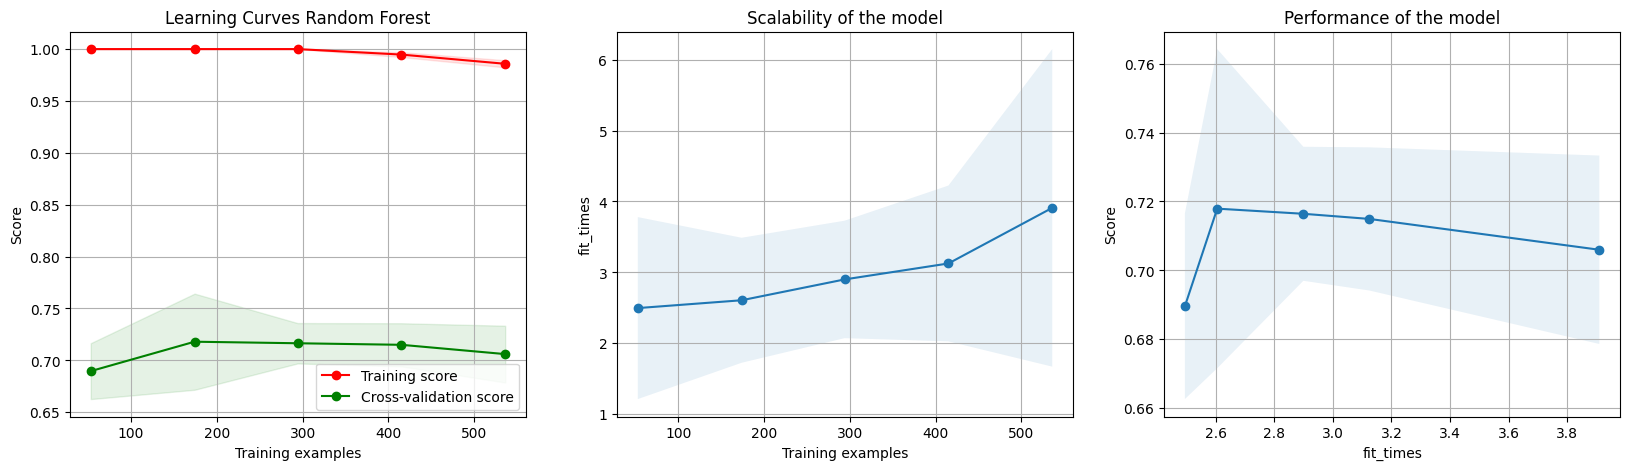

In [82]:
plot_learning_curve(loaded_best_estimator_round2, 'Learning Curves Random Forest', X_train, y_train, n_jobs=-1)

In [85]:
#let's check the train scores
print(loaded_best_estimator_round2.score(X_train,y_train))

#let's check the cross validation score
print(loaded_complete_grid_round2.best_score_)

0.982089552238806
0.7218045112781954


In [86]:
results = pd.DataFrame(loaded_complete_grid_round2.cv_results_)
results.head()
# sort the results by mean_test_score
results.sort_values(by='mean_test_score', ascending=False, inplace=True)

results.reset_index(drop=True, inplace=True)

results[[
    'param_rfc__max_features',
    'param_rfc__max_depth',
    'mean_test_score', 'std_test_score', 'mean_train_score'
]].head(20)

,param_rfc__max_features,param_rfc__max_depth,mean_test_score,std_test_score,mean_train_score
0,None,7,0.742857,0.085714,1.000000
1,None,3,0.742857,0.085714,0.955932
2,None,5,0.742857,0.085714,1.000000
3,None,4,0.728571,0.083299,0.993220
4,None,9,0.728571,0.104978,1.000000
5,None,8,0.728571,0.104978,1.000000
6,None,9,0.721805,0.024247,0.995865
7,None,8,0.721805,0.025608,0.984586
8,None,7,0.720301,0.020398,0.963158
9,None,2,0.714286,0.101015,0.884746


## More Hyperparameter tuning

In [88]:
# now we create the grid with all the parameters that we would like to test.

param_grid_3= {
    'rfc__n_estimators' :[380],
    'rfc__max_features' : [None],
    'rfc__max_depth': np.arange(8, 13),
    'rfc__min_samples_leaf': np.arange(2, 6),
    'rfc__max_leaf_nodes': np.arange(16, 30, 2),
    }

# now we set up the grid search with cross-validation
grid_rf_3 = HalvingRandomSearchCV(credit_risk_pipeline_2, param_distributions=param_grid_3,  cv=5, return_train_score= True, n_jobs=-1)

In [89]:
grid_rf_3.fit(X_train, y_train)

HalvingRandomSearchCV(estimator=Pipeline(steps=[('rare_label_encoder',
                                                 RareLabelEncoder(variables=['credit_history',
                                                                             'purpose',
                                                                             'savings_status',
                                                                             'personal_status',
                                                                             'other_parties',
                                                                             'other_payment_plans',
                                                                             'job'])),
                                                ('one_hot_encoder',
                                                 OneHotEncoder(drop_last=True,
                                                               ignore_format=True,
                                                               variables=['checking_status',
                                                                          'credit_history',
                                                                          'purpose',
                                                                          'savings_status',
                                                                          'em...
                                                                          'existing_credits',
                                                                          'num_dependents'])),
                                                ('convert_to_numpy',
                                                 ConvertToNumpyArray()),
                                                ('rfc',
                                                 RandomForestClassifier(oob_score=True,
                                                                        random_state=42))]),
                      n_jobs=-1,
                      param_distributions={'rfc__max_depth': array([ 8,  9, 10, 11, 12]),
                                           'rfc__max_features': [None],
                                           'rfc__max_leaf_nodes': array([16, 18, 20, 22, 24, 26, 28]),
                                           'rfc__min_samples_leaf': array([2, 3, 4, 5]),
                                           'rfc__n_estimators': [380]})

In [90]:
#Let's check the best_parameters from GridSearchCv for our model
print(grid_rf_3.best_params_)

{'rfc__n_estimators': 380, 'rfc__min_samples_leaf': 2, 'rfc__max_leaf_nodes': 22, 'rfc__max_features': None, 'rfc__max_depth': 9}


In [91]:
file_best_estimator_round3 = save_model_folder / 'rf_round3_params.pkl'
file_complete_grid_round3 = save_model_folder / 'rf_round3_model.pkl'

In [92]:
joblib.dump(grid_rf_3.best_estimator_, file_best_estimator_round3)
joblib.dump(grid_rf_3, file_complete_grid_round3)

['/content/drive/MyDrive/BUAN6341/HW7/models/ml_fall_2022/rf_round3_model.pkl']

In [93]:
loaded_best_estimator_round3 = joblib.load(file_best_estimator_round3)
loaded_complete_grid_round3 = joblib.load(file_complete_grid_round3)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

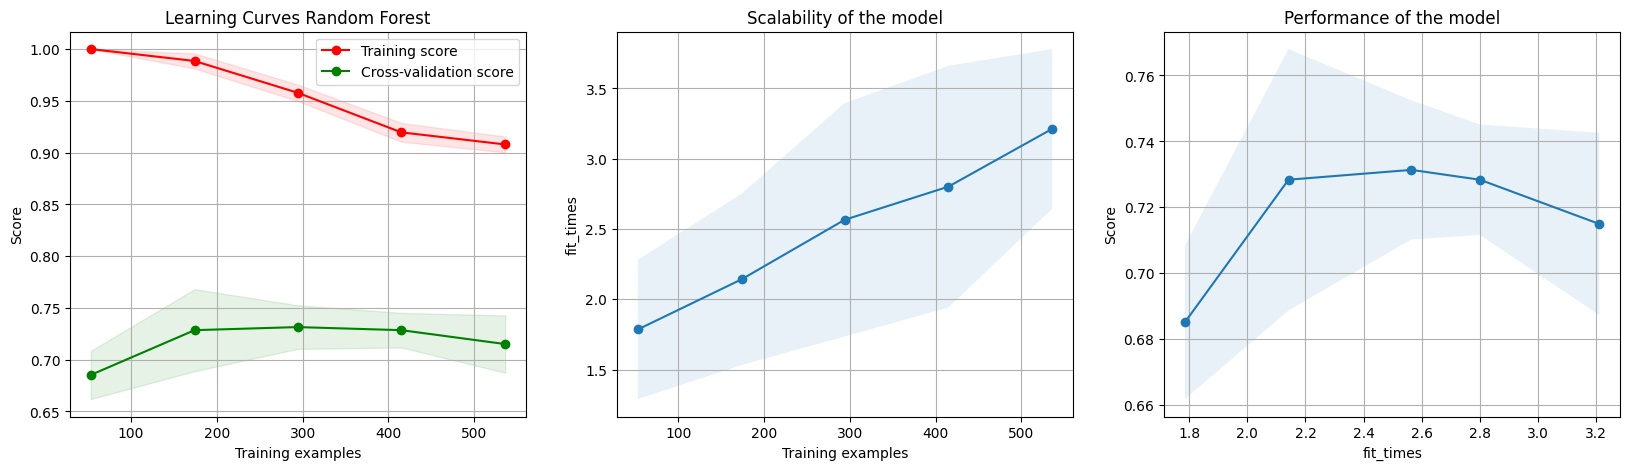

In [94]:
plot_learning_curve(loaded_best_estimator_round3 , 'Learning Curves Random Forest', X_train, y_train, n_jobs=-1)

In [95]:
#let's check the train scores
print(loaded_best_estimator_round3.score(X_train,y_train))

#let's check the cross validation score
print(loaded_complete_grid_round3.best_score_)

0.8955223880597015
0.725925925925926


## Modifying the Pipeline

In [96]:
credit_risk_preprocessing_1 = Pipeline([

    ('rare_label_encoder',
      RareLabelEncoder(tol=0.05, variables=var_rare_labels)),

    ('one_hot_encoder',
     OneHotEncoder(variables=categorical + discrete, drop_last=True, ignore_format=True))
])

In [97]:
credit_risk_pipeline_3 = Pipeline([

    ('rare_label_encoder',
      RareLabelEncoder(tol=0.05, variables=var_rare_labels)),

    ('one_hot_encoder',
     OneHotEncoder(variables=categorical + discrete, drop_last=True, ignore_format=True)),

    ('rfc', RandomForestClassifier(oob_score=True, random_state=42))
])

In [98]:
# Preprocessing - Train data
X_train_processed_1 = credit_risk_preprocessing_1.fit_transform(X_train)

In [99]:
train_scores = []
oob_scores = []
best_oob_score = 0
best_n_estimators = 50

rfc_1 = RandomForestClassifier(warm_start=True, random_state=42, oob_score=True)
estimator_range = range(50, 500, 10)
for n_estimators in estimator_range:
    rfc_1.n_estimators = n_estimators
    rfc_1.fit(X_train_processed, y_train)
    train_scores.append(rfc_1.score(X_train_processed_1, y_train))
    oob_scores.append(rfc_1.oob_score_)
    if rfc_1.oob_score_ > best_oob_score:
        best_n_estimators_1 = n_estimators
        best_oob_score = rfc_1.oob_score_


In [100]:
print(best_n_estimators_1)

380


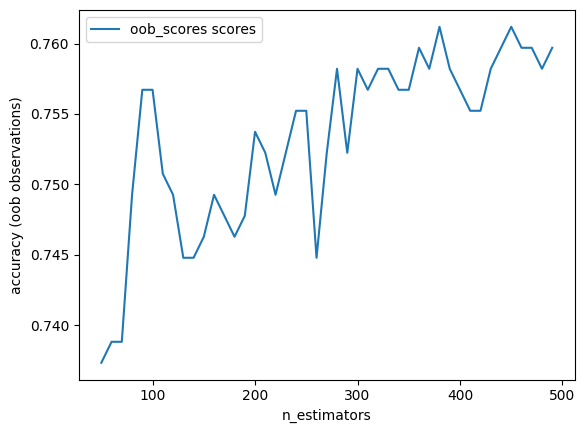

In [101]:
plt.plot(estimator_range, oob_scores, label="oob_scores scores")
plt.ylabel("accuracy (oob observations)")
plt.xlabel("n_estimators")
plt.legend()
plt.show()

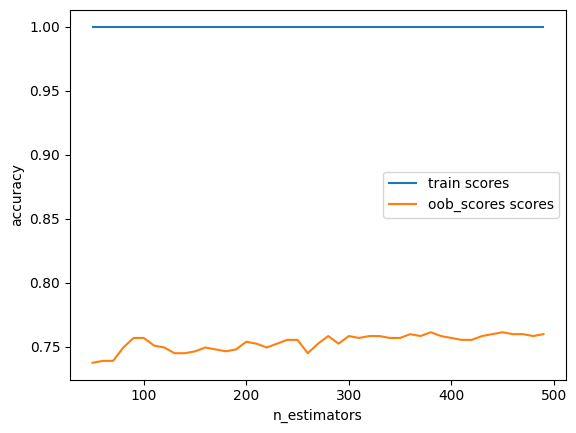

In [102]:
plt.plot(estimator_range, train_scores, label="train scores")
plt.plot(estimator_range, oob_scores, label="oob_scores scores")
plt.ylabel("accuracy")
plt.xlabel("n_estimators")
plt.legend()
plt.show()

In [103]:
# now we create the grid with all the parameters that we would like to test.

param_grid_4= {
    'rfc__n_estimators' :[380],
    'rfc__max_features' : ["sqrt", None],
    'rfc__max_depth': np.arange(7, 12),
    'rfc__min_samples_leaf': np.arange(2, 6),
    'rfc__max_leaf_nodes': np.arange(16, 30, 2),
    }

# now we set up the grid search with cross-validation
grid_rf_4 = HalvingRandomSearchCV(credit_risk_pipeline_3, param_distributions=param_grid_4,  cv=5, return_train_score= True, n_jobs=-1)

In [104]:
grid_rf_4.fit(X_train, y_train)

HalvingRandomSearchCV(estimator=Pipeline(steps=[('rare_label_encoder',
                                                 RareLabelEncoder(variables=['credit_history',
                                                                             'purpose',
                                                                             'savings_status',
                                                                             'personal_status',
                                                                             'other_parties',
                                                                             'other_payment_plans',
                                                                             'job'])),
                                                ('one_hot_encoder',
                                                 OneHotEncoder(drop_last=True,
                                                               ignore_format=True,
                                                               variables=['checking_status',
                                                                          'credit_history',
                                                                          'purpose',
                                                                          'savings_status',
                                                                          'em...
                                                                          'installment_commitment',
                                                                          'residence_since',
                                                                          'existing_credits',
                                                                          'num_dependents'])),
                                                ('rfc',
                                                 RandomForestClassifier(oob_score=True,
                                                                        random_state=42))]),
                      n_jobs=-1,
                      param_distributions={'rfc__max_depth': array([ 7,  8,  9, 10, 11]),
                                           'rfc__max_features': ['sqrt', None],
                                           'rfc__max_leaf_nodes': array([16, 18, 20, 22, 24, 26, 28]),
                                           'rfc__min_samples_leaf': array([2, 3, 4, 5]),
                                           'rfc__n_estimators': [380]})

In [105]:
#Let's check the best_parameters from GridSearchCv for our model
print(grid_rf_4.best_params_)

{'rfc__n_estimators': 380, 'rfc__min_samples_leaf': 2, 'rfc__max_leaf_nodes': 28, 'rfc__max_features': 'sqrt', 'rfc__max_depth': 7}


In [106]:
file_best_estimator_round4 = save_model_folder / 'rf_round4_params.pkl'
file_complete_grid_round4 = save_model_folder / 'rf_round4_model.pkl'

In [107]:
joblib.dump(grid_rf_4.best_estimator_, file_best_estimator_round4)
joblib.dump(grid_rf_4, file_complete_grid_round4)

['/content/drive/MyDrive/BUAN6341/HW7/models/ml_fall_2022/rf_round4_model.pkl']

In [108]:
loaded_best_estimator_round4 = joblib.load(file_best_estimator_round4)
loaded_complete_grid_round4 = joblib.load(file_complete_grid_round4)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

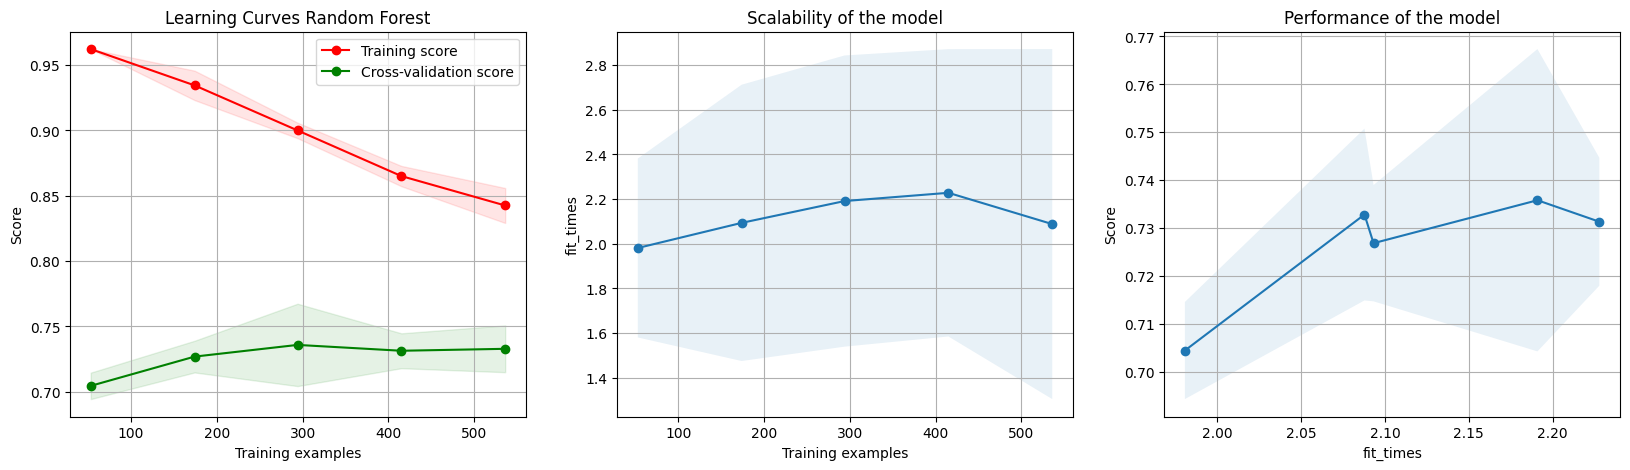

In [109]:
plot_learning_curve(loaded_best_estimator_round4 , 'Learning Curves Random Forest', X_train, y_train, n_jobs=-1)

In [110]:
#let's check the train scores
print(loaded_best_estimator_round4.score(X_train,y_train))

#let's check the cross validation score
print(loaded_complete_grid_round4.best_score_)

0.8149253731343283
0.7277777777777777


## Performing some more Hyperparameter tuning

In [114]:
# now we create the grid with all the parameters that we would like to test.

param_grid_5= {
    'rfc__n_estimators' :[380],
    'rfc__max_features' : ['sqrt'],
    'rfc__max_depth': np.arange(7, 12),
    'rfc__min_samples_leaf': [1, 2, 3, 4, 5],
    'rfc__max_leaf_nodes': [25, 26, 27, 28, 29, 30],
    }

# now we set up the grid search with cross-validation
grid_rf_5 = HalvingRandomSearchCV(credit_risk_pipeline_2, param_distributions=param_grid_5,  cv=5, return_train_score= True, n_jobs=-1)

In [115]:
grid_rf_5.fit(X_train, y_train)

HalvingRandomSearchCV(estimator=Pipeline(steps=[('rare_label_encoder',
                                                 RareLabelEncoder(variables=['credit_history',
                                                                             'purpose',
                                                                             'savings_status',
                                                                             'personal_status',
                                                                             'other_parties',
                                                                             'other_payment_plans',
                                                                             'job'])),
                                                ('one_hot_encoder',
                                                 OneHotEncoder(drop_last=True,
                                                               ignore_format=True,
                                                               variables=['checking_status',
                                                                          'credit_history',
                                                                          'purpose',
                                                                          'savings_status',
                                                                          'em...
                                                                          'existing_credits',
                                                                          'num_dependents'])),
                                                ('convert_to_numpy',
                                                 ConvertToNumpyArray()),
                                                ('rfc',
                                                 RandomForestClassifier(oob_score=True,
                                                                        random_state=42))]),
                      n_jobs=-1,
                      param_distributions={'rfc__max_depth': array([ 7,  8,  9, 10, 11]),
                                           'rfc__max_features': ['sqrt'],
                                           'rfc__max_leaf_nodes': [25, 26, 27,
                                                                   28, 29, 30],
                                           'rfc__min_samples_leaf': [1, 2, 3, 4,
                                                                     5],
                                           'rfc__n_estimators': [380]})

In [116]:
#Let's check the best_parameters from GridSearchCv for our model
print(grid_rf_5.best_params_)

{'rfc__n_estimators': 380, 'rfc__min_samples_leaf': 1, 'rfc__max_leaf_nodes': 28, 'rfc__max_features': 'sqrt', 'rfc__max_depth': 8}


In [117]:
file_best_estimator_round5 = save_model_folder / 'rf_round5_params.pkl'
file_complete_grid_round5 = save_model_folder / 'rf_round5_model.pkl'

In [118]:
joblib.dump(grid_rf_5.best_estimator_, file_best_estimator_round5)
joblib.dump(grid_rf_5, file_complete_grid_round5)

['/content/drive/MyDrive/BUAN6341/HW7/models/ml_fall_2022/rf_round5_model.pkl']

In [119]:
loaded_best_estimator_round5 = joblib.load(file_best_estimator_round5)
loaded_complete_grid_round5 = joblib.load(file_complete_grid_round5)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

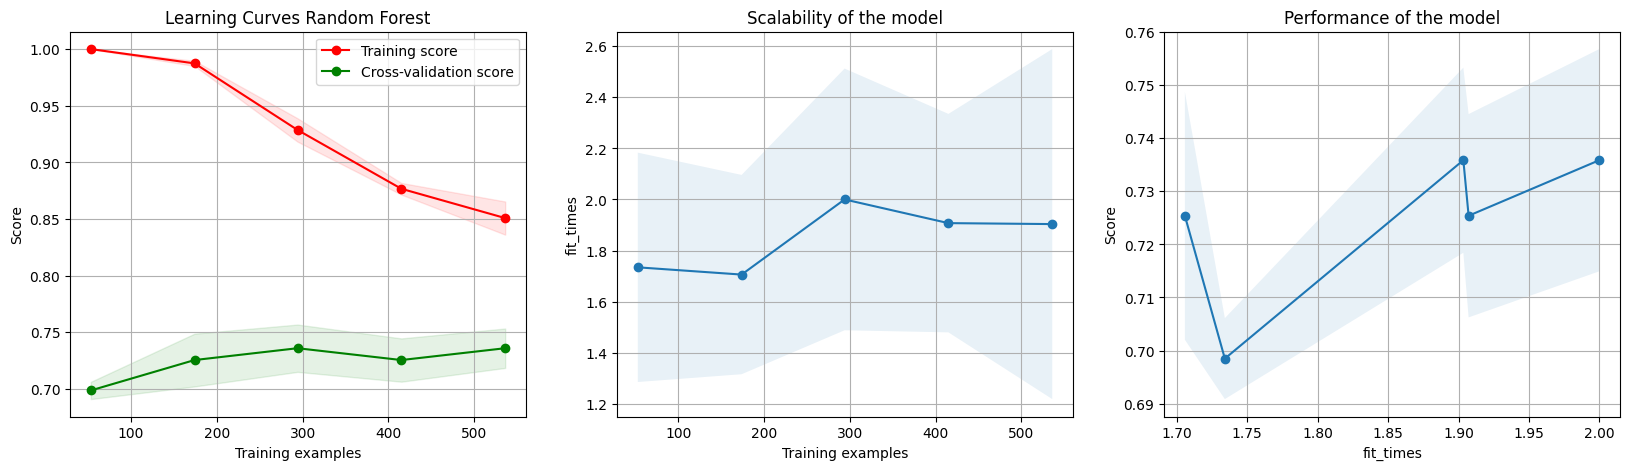

In [120]:
plot_learning_curve(loaded_best_estimator_round5 , 'Learning Curves Random Forest', X_train, y_train, n_jobs=-1)

In [121]:
#let's check the train scores
print(loaded_best_estimator_round5.score(X_train,y_train))

#let's check the cross validation score
print(loaded_complete_grid_round5.best_score_)

0.826865671641791
0.7203703703703702


## Performance on Test Data

In [122]:
file_best_estimator_rf = save_model_folder / 'rf_round5_params.pkl'
best_estimator_rf = joblib.load(file_best_estimator_rf)

In [123]:
print(f'Test data accauracy for round 5: {best_estimator_rf .score(X_test,y_test)}')

Test data accauracy for round 5: 0.7272727272727273


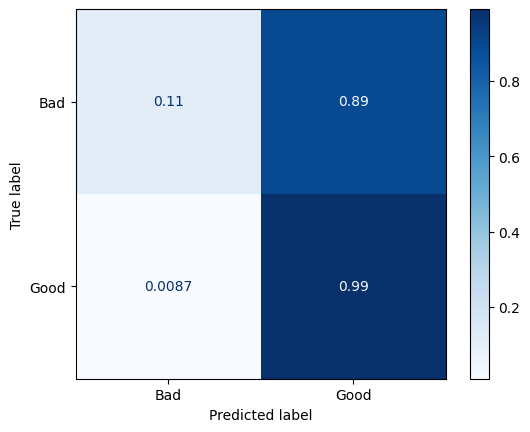

In [124]:
ConfusionMatrixDisplay.from_estimator(best_estimator_rf, X_test, y_test,
                                 display_labels=['Bad', 'Good'],
                                 cmap=plt.cm.Blues,
                                 normalize = 'true')
plt.grid(False)
plt.show()

Comparing KNN/Logistic Regression/SVM vs Random Forest, for KNN we get training and cv score of 80% and 73% resp. indicating overfitting. Compared to Logistic Regression, the train and cv score was of 77.6% and 73.4% resp., whereas Support Vector Classifier (SVC) heavily overfits the data despite of hyperparameter tuning, where the train and cross validation (cv) scores were ~93% and ~74% resp. Here, Random Forest Classifier also follows a very similar trend as SVC, but after some cross validation and hyperparameter tuning, the initial overfitting of Random Forest Classifier reduces, and the learning curves start to straighten out, indicating that more amount of data can help in reducing the overfitting, however, as for the given 'credit-g' dataset, Logistic Regression is still better as it experiences very less overfitting compared to other algorithms.   